In [2]:
def load_clinical_eeg_data(datapath, sub):
    # input arguments:
    # datapath (string): path to the root directory
    # sub (string): subject ID (e.g. chb01, chb02, etc)
    
    # output:
    # eegdata (numpy array): samples x channels data matrix
    # eegevents (pandas dataframe): labels and chunks
    # channel_names (list): names of the channels
    import pandas as pd
    alldata = pd.read_csv(os.path.join(datapath, 'train', sub + '.csv'))
    alldata.rename(columns={'Unnamed: 0': 'Index'})
    eegevents = alldata[['labels', 'chunks']]
    alldata.drop(['Unnamed: 0', 'labels', 'chunks'], axis=1, inplace=True)
    names = alldata.keys()
    return alldata.iloc[:].as_matrix(), eegevents, names

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cross_validation as cv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals import joblib
import sklearn.metrics as metrics

In [221]:
import os

data, label_chunk, nodes =load_clinical_eeg_data('/Users/Matisse/Desktop', 'chb01')

In [222]:
from sklearn.decomposition import PCA
import sklearn.preprocessing as prepro

x_scaled = prepro.scale(data)

pca = PCA(n_components = 7)
x_pca = pca.fit_transform(x_scaled)

In [223]:
#Jeff Code

def apply_filters(x, order=4, fs=512.0, filt=None, btype='low', axis=0):
    from scipy.signal import butter, filtfilt
    nyq = .5 * fs
    
    if filt is None:
        return x
    if isinstance(filt, list):
        f = [i/nyq for i in filt]
        btype='band'
    else:
        f = filt/nyq
        
    b, a = butter(order, f, btype=btype, analog=False)
    x = filtfilt(b, a, x, axis=axis)
    return x

def plot_filter(order=4, fs=512.0, filt=None, btype='low'):
    from scipy.signal import decimate, butter, freqs
    nyq = .5 * fs
    if filt is None:
        return None
    if isinstance(filt, list) and len(filt) > 1:
        f = [i/nyq for i in filt]
        btype='band'
    else:
        f = filt/nyq
    b, a = butter(order, f, btype=btype, analog=True)
    w, h = freqs(b, a)
    plt.plot(w, 20 * np.log10(abs(h)))
    plt.xscale('log')
    plt.title('Butterworth filter frequency response')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(100, color='green') # cutoff frequency
    plt.show()

f, axarr = plt.subplots(4, 1, figsize=(8, 6))
axarr[0].plot(data[:,0])
axarr[0].set_title('raw')


x_filt = apply_filters(data[:,0], order=4, fs=64, filt=5, btype='high')
axarr[1].plot(x_filt)
axarr[1].set_title('hp-filtered')


x_filt = apply_filters(data[:,0], order=4, fs=64, filt=25, btype='low')
axarr[2].plot(x_filt)
axarr[2].set_title('lp-filtered')

x_filt = apply_filters(data[:,0], order=4, fs=64, filt=[12, 30], btype='band')
axarr[3].plot(x_filt)
axarr[3].set_title('bp-filtered')
plt.show()

In [224]:
bp_data = apply_filters(data,order =4, fs=64, filt=[12, 30], btype='band')

In [225]:
# Our dataset is very one-sided, and wee need to sample evenly to avoid our models only predicting "no seizure"
def re_label(data,labels):
    non_szr = []
    pre_szr = []
    szr = []

    marker = 0
    f_label = labels
    f_data = data
    for i in range(0, len(f_label)):
        if f_label[i] == 0:
            marker = 0
            if i < len(f_label) - 640 and f_label[i + 640] != 1:
                non_szr.append(f_data[i])

        elif f_label[i] == 1 and marker == 0:
            marker = 1

            for n in range(640, 1, -1):
                pre_szr.append(f_data[i - n])

        elif f_label[i] == 1 and marker == 1:
            szr.append(f_data[i])

    pre_szr = np.asarray(pre_szr)
    szr = np.asarray(szr)
    non_szr = np.asarray(non_szr)
    
    return non_szr, szr, pre_szr

def sample_sizer(labelList, n, *args):
    samples = []
    for arg in args:
        for i in range(n):
            samples.append(arg[i,:])
            
    labelr = []
    for labels in labelList:
        for i in range(n):
            labelr.append(labels)
    return np.array(samples), np.array(labelr)

In [226]:
#Build equally sized data sets
def new_balanced_dataset(data, labels):
    nonData, seizData, preData = re_label(data, labels)

    #Shuffle each list
    np.random.shuffle(nonData)
    np.random.shuffle(seizData)
    np.random.shuffle(preData)

    #generate a new dataset
    size = 64 * 30 # ~30 sec of each data type
    new_data, new_labels = sample_sizer([0,1], size, nonData, preData)
    
    return new_data, new_labels

labels = np.array(label_chunk)[:,0]
new_data, new_labels = new_balanced_dataset(data, labels)

In [ ]:
def predict_log_reg(data, label_chunk):
    
    labels = np.array(label_chunk)[:,0]
    new_data, new_labels = new_balanced_dataset(data, labels)
    
    training_set, testing_set, training_labels, testing_labels = cv.train_test_split(new_data, new_labels)
    
    log_reg_model = LogisticRegression()
    log_reg_model.fit(training_set, training_labels)
    print "Training accuracy: " + str(log_reg_model.score(training_set, training_labels))
    print "Testing accuracy: "+ str(log_reg_model.score(testing_set,testing_labels))
    
    
def predict_k_neighbors(data, label_chunk):
    
    labels = np.array(label_chunk)[:,0]
    new_data, new_labels = new_balanced_dataset(data, labels)
    
    training_set, testing_set, training_labels, testing_labels = cv.train_test_split(new_data, new_labels)
    
    Ks = np.linspace(1, 50, 50)
    scores = []
    for i in range(len(Ks)):
        neighbors = KNeighborsClassifier(Ks[i])
        neighbors.fit(training_set, training_labels)
        meanscore = np.mean(cv.cross_val_score(neighbors, training_set, training_labels))
        scores.append(meanscore)
    scores = np.array(scores)
    k = Ks[scores == scores.max()]
    
    neighbors = KNeighborsClassifier(k)
    neighbors.fit(training_set, training_labels)
    print "Training accuracy: " + str(neighbors.score(training_set, training_labels))
    print "Testing accuracy: "+ str(neighbors.score(testing_set, testing_labels))

In [ ]:
# predict_log_reg(bp_data, label_chunk)
# predict_k_neighbors(bp_data, label_chunk)

In [228]:
training_set, testing_set, training_labels, testing_labels = cv.train_test_split(new_data, new_labels)

In [229]:
# logistic regression on balanced dataset

from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression()
log_reg_model.fit(training_set, training_labels)
print "Training accuracy:" + str(log_reg_model.score(training_set, training_labels))
print"Testing accuracy"+ str(log_reg_model.score(testing_set,testing_labels))

# model_name = 'log_reg_predict.pkl'
# joblib.dump(log_reg_model, model_name)

Training accuracy:0.519791666667
Testing accuracy0.469791666667


In [230]:
predict_logreg=log_reg_model.decision_function(testing_set)
fpr1, tpr1, thresholds = metrics.roc_curve(testing_labels,predict_logreg)
plt.plot(fpr1,tpr1)
plt.title('ROC Curve')
x=[0,1]
y=[0,1]
plt.plot(x,y)
plt.show(block=True)

AUC:  0.488430557247
Accuracy:  0.469791666667


In [231]:
print 'AUC: ', metrics.auc(fpr1,tpr1)
print 'Accuracy: ', log_reg_model.score(testing_set,testing_labels)

AUC:  0.488430557247
Accuracy:  0.469791666667


In [236]:
# k-nearest neighbors on balanced dataset

from sklearn.neighbors import KNeighborsClassifier

Ks = np.linspace(1, 50, 50)
scores = []
for i in range(len(Ks)):
    neighbors = KNeighborsClassifier(Ks[i])
    neighbors.fit(training_set, training_labels)
    meanscore = np.mean(cv.cross_val_score(neighbors, training_set, training_labels))
    scores.append(meanscore)
scores = np.array(scores)
k = Ks[scores == scores.max()]

In [238]:
neighbors = KNeighborsClassifier(k)
neighbors.fit(training_set, training_labels)
print "Training accuracy: " + str(neighbors.score(training_set, training_labels))
print"Testing accuracy: "+ str(neighbors.score(testing_set, testing_labels))

# model_name = 'knn_predict.pkl'
# joblib.dump(neighbors, model_name)

Training accuracy: 0.71875
Testing accuracy: 0.616666666667


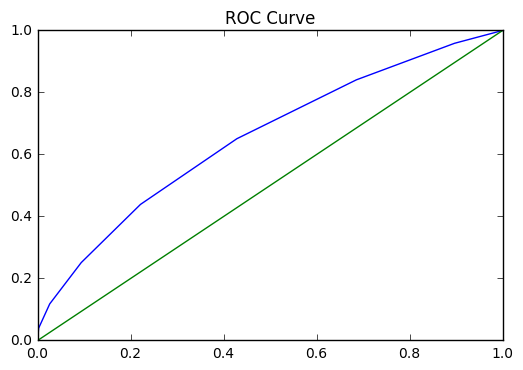

AUC:  0.654245463561
Accuracy:  0.616666666667


In [239]:
predict_knn=neighbors.predict_proba(testing_set)
fpr2, tpr2, thresholds = metrics.roc_curve(testing_labels,predict_knn[:, 1])
plt.plot(fpr2, tpr2)
plt.title('ROC Curve')
x=[0,1]
y=[0,1]
plt.plot(x,y)
plt.show(block=True)

print 'AUC: ', metrics.auc(fpr2,tpr2)
print 'Accuracy: ', neighbors.score(testing_set, testing_labels)

In [207]:
# def run_skl_model(x, modelname):
#     from sklearn.externals import joblib
#     clf = joblib.load(modelname)  # load the saved sklearn model (so you don't have to retrain)
#     return clf.predict(x)
# 
# run_skl_model(testing_set, 'log_reg_predict.pkl')

Training accuracy:0.991404341126
Testing accuracy0.990962350697


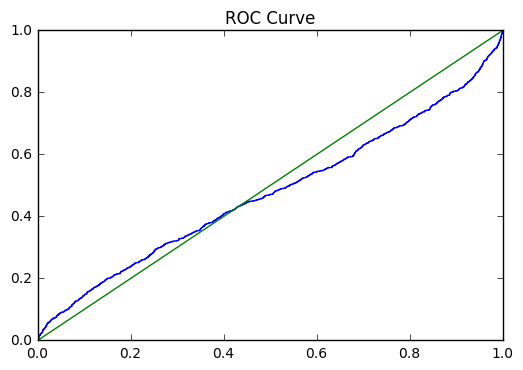

AUC:  0.476093086883
Accuracy:  0.990962350697


In [209]:
unbalanced_data = np.append(nonData, preData, axis=0)
unbalanced_labels = np.append(np.repeat(0, nonData.shape[0]), np.repeat(1, preData.shape[0]))

training_set, testing_set, training_labels, testing_labels = cv.train_test_split(unbalanced_data, unbalanced_labels)

log_reg_model = LogisticRegression()
log_reg_model.fit(training_set, training_labels)
print "Training accuracy:" + str(log_reg_model.score(training_set, training_labels))
print"Testing accuracy"+ str(log_reg_model.score(testing_set,testing_labels))

predict_logreg=log_reg_model.decision_function(testing_set)
fpr1, tpr1, thresholds = metrics.roc_curve(testing_labels,predict_logreg)
plt.plot(fpr1,tpr1)
plt.title('ROC Curve')
x=[0,1]
y=[0,1]
plt.plot(x,y)
plt.show(block=True)

print 'AUC: ', metrics.auc(fpr1,tpr1)
print 'Accuracy: ', log_reg_model.score(testing_set,testing_labels)